In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
import gc
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool
#from apex import amp
import pickle
from efficientnet_pytorch import EfficientNet
import pretrainedmodels as pm
import torchvision.models as M 
from sklearn.metrics import average_precision_score
from losses import FocalLoss, RegL1Loss

PATH = './data/'
SAVE_PATH = './'
#os.listdir(PATH)

In [2]:
## Constants
SWITCH_LOSS_EPOCH = 0
print(torch.__version__)

1.3.1


In [3]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
bad_list = ['ID_1a5a10365',
'ID_1db0533c7',
'ID_53c3fe91a',
'ID_408f58e9f',
'ID_4445ae041',
'ID_bb1d991f6',
'ID_c44983aeb',
'ID_f30ebe4d4']
train = train.loc[~train['ImageId'].isin(bad_list)].reset_index(drop=True)
# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

In [4]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [5]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

#plt.figure(figsize=(14,14))
#plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'))
#plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

xs, ys = [], []

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

#plt.figure(figsize=(18,18))
#plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
#plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

In [6]:
# Cars points
xs, ys = [], []
for ps in train['PredictionString']:
    coords = str2coords(ps)
    xs += [c['x'] for c in coords]
    ys += [c['y'] for c in coords]

# Road points
road_width = 6
road_xs = [-road_width, road_width, road_width, -road_width, -road_width]
road_ys = [0, 0, 500, 500, 0]

In [7]:
# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_line(image, points):
    color = (255, 0, 0)
    # points.shape (5,3)
    # 图片中四边形第1个点(x0,y0)与第4个点(x3,y3)之间的连线
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    # 图片中四边形第1个点(x0,y0)与第2个点(x1,y1)之间的连线
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    # 图片中四边形第2个点(x1,y1)与第3个点(x2,y2)之间的连线
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    # 图片中四边形第2个点(x0,y0)与第4个点(x3,y3)之间的连线
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image
"""
通过欧拉角，相机内参，空间向量坐标，可以求出在图片中，
该点上这辆车所在的中心点位置和该辆车所在的边框的4个顶点坐标
"""
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math,生成(4,4)的one-hot矩阵
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        # img_cor_points[-1:]表示输出最后一项
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [8]:
IMG_WIDTH = 1800
IMG_HEIGHT = 600 #IMG_WIDTH // 4
MODEL_SCALE = 8
# 对roll和pich进行转换
def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict
# 把roll和pitch转换回
def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1 # 中心点为1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

img0 = imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, train['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

img.shape (600, 1800, 3) std: 0.28710672
mask.shape (75, 225) std: 0.017210707
regr.shape (75, 225, 7) std: 0.0072774757


In [9]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr]

In [10]:
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

train = pd.read_csv('train_fold10-2.csv')
valid_idx = 0
#df_train, df_dev = train_test_split(train[['ImageId','PredictionString']], test_size=0.01, random_state=233)
df_train = train[train['fold']!=valid_idx][['ImageId','PredictionString']]
df_dev = train[train['fold']==valid_idx][['ImageId','PredictionString']]
df_dev2 = df_dev.copy()
df_test = test

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir)
dev_dataset = CarDataset(df_dev, train_images_dir)
test_dataset = CarDataset(df_test, test_images_dir)

img, mask, regr = train_dataset[0]

In [11]:
BATCH_SIZE = 2

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [12]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x
# 上采样结构
# 如果 bilinear == True, 用双线性差值进行上采样, 尺寸 * 2
# 如果 bilinear == False, 用转置卷积进行上采样, 其输入通道数 = 输出通道数 = in_ch // 2, stride=2，表示尺寸 * 2
# 该层的输入是相邻的两个下采样层的输出
# x1 是由 x2 下采样得到的
# 先对 x1 进行上采样，比较上采样后的 x1 与 x2 的尺寸, 如果不同那么一定是 x1 的尺寸大于 x2 的尺寸
# 在 x2 的四周进行补 0, 使其与 x1 有相同的尺寸
# 对 x1 和 x2 进行级联，级联后的维度就是 in_ch
# 然后对 cat(x1, x2) 进行卷积，卷积后的维度为 out_ch

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # 镜像padding
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [13]:
class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = M.resnet101(pretrained=True)
        #EfficientNet.from_pretrained('efficientnet-b0')#pm.se_resnext101_32x4d(pretrained='imagenet')#
        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1029, 512) #up(1282 + 1024, 512) #up(3074, 512)
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.avgpool(x_center) #extract_features(x_center) #features(x_center) #
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [14]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#torch.cuda.set_device(0)

n_epochs = 30 #6
lr = 0.001

model = CentResnet(8).cuda()
optimizer = optim.AdamW(model.parameters(), lr=lr)
#optimizer =  RAdam(model.parameters(), lr = 0.001)

#model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
model = nn.DataParallel(model)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda


In [15]:
def criterion(prediction, mask, regr, weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    #mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    #mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    #mask_loss = -mask_loss.mean(0).sum()
    mask_loss = FocalLoss()(pred_mask, mask)
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    #regr_loss = RegL1Loss()
  
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss, mask_loss, regr_loss

In [16]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0
# 这里相当与nms
def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            # 把xy1 和 xy2数组中的数值分别相加，然后分别平方，然后再把数组中的所有项相加。最后把加和开平方
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction):
    logits = prediction[0]
    regr_output = prediction[1:]
    # np.argwhere(logits > 0)返回logits中结果大于0的索引，[(x1,y1),(x2,y2),....]
    points = np.argwhere(logits > 0)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        # 利用sigmoid函数对来求最后的置信度，并对coords的最后一项进行修改
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [17]:
def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

In [18]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores

In [19]:
iter_size = 1

def train(epoch, optimizer, history=None):
    model.train()
    t = tqdm(train_loader)
    optimizer.zero_grad()
    loss2 = 0.
    mask_loss2 = 0.
    regr_loss2 = 0.
    loss3 = 0.
    mask_loss3 = 0.
    regr_loss3 = 0.    
    
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(t):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)        
        
        output = model(img_batch)
        
        if epoch < SWITCH_LOSS_EPOCH :
            loss, mask_loss, regr_loss = criterion(output, mask_batch, regr_batch, 1)
        else:
            loss, mask_loss, regr_loss = criterion(output, mask_batch, regr_batch, 0.5)
        loss2 += loss/iter_size
        mask_loss2 += mask_loss/iter_size
        regr_loss2 += regr_loss/iter_size
        loss3 += loss/iter_size
        mask_loss3 += mask_loss/iter_size
        regr_loss3 += regr_loss/iter_size
        loss = loss/iter_size
        #with amp.scale_loss(loss, optimizer) as scaled_loss:
        #    scaled_loss.backward()
        loss.backward()
        
        if (batch_idx+1) % iter_size == 0:
        
            t.set_description(f'train_loss (l={loss2:.3f})(m={mask_loss2:.2f}) (r={regr_loss2:.4f}')

            if history is not None:
                history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss2.data.cpu().numpy()

            optimizer.step()
            optimizer.zero_grad()
            #exp_lr_scheduler.step()

            loss2 = 0.
            mask_loss2 = 0.
            regr_loss2 = 0.
        
        del img_batch, mask_batch, regr_batch
        gc.collect()

    loss3 = loss3/(batch_idx+1)
    mask_loss3 = mask_loss3/(batch_idx+1)
    regr_loss3 = regr_loss3/(batch_idx+1)   

    torch.save(model.state_dict(), SAVE_PATH+'model{}.pth'.format(epoch))
    print('loss: {:.4f} \tmask: {:.4f} \tregr: {:.4f}'.format(loss3, mask_loss3, regr_loss3))

def evaluate(epoch): #, history=None):
    
    model.eval()
    loss = 0
    valid_loss = 0
    valid_mask_loss = 0
    valid_regr_loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            if epoch < SWITCH_LOSS_EPOCH :
                loss, mask_loss, regr_loss= criterion(output, mask_batch, regr_batch, 1, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            else :
                loss, mask_loss, regr_loss = criterion(output, mask_batch, regr_batch, 0.5, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            
            del img_batch, mask_batch, regr_batch
            gc.collect()
    
    valid_loss /= len(dev_loader.dataset)
    valid_mask_loss /= len(dev_loader.dataset)
    valid_regr_loss /= len(dev_loader.dataset)
    
    '''
    if history is not None:
        history.loc[epoch, 'dev_loss'] = valid_loss.cpu().numpy()
        history.loc[epoch, 'mask_loss'] = valid_mask_loss.cpu().numpy()
        history.loc[epoch, 'regr_loss'] = valid_regr_loss.cpu().numpy()
    '''
    
    print('Epoch: {} \tLR: {:.6f} \tDev loss: {:.4f}'.format(epoch, lr, valid_loss))
    
    return valid_loss

In [ ]:
history = pd.DataFrame()
#history2 = pd.DataFrame()
best_valid_loss = 100000.
best_mAP = -1.
patience = 2
lr_changes = 0
max_lr_changes = 2
lr_reset_epoch = 0
valid_losses = []
mAPs = []

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, optimizer, history)
    valid_loss = evaluate(epoch)#, history2)
    valid_losses.append(valid_loss)
    
    if epoch >= 4:
        val_preds = []
        model.eval()
        for img, _, _ in tqdm(dev_loader):
            with torch.no_grad():
                output = model(img.to(device))
            output = output.data.cpu().numpy()
            for out in output:
                coords = extract_coords(out)
                s = coords2str(coords)
                val_preds.append(s)
        df_dev2['PredictionString'] = val_preds
        df_dev2.to_csv('val_predictions.csv', index=False)
        
        valid_df = pd.read_csv('val_predictions.csv')
        expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
        valid_df = valid_df.fillna('')

        train_df = pd.read_csv('./data/train.csv')
        train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
        # data description page says, The pose information is formatted as
        # model type, yaw, pitch, roll, x, y, z
        # but it doesn't, and it should be
        # model type, pitch, yaw, roll, x, y, z
        expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

        max_workers = 1
        n_gt = len(expanded_train_df)
        ap_list = []
        p = Pool(processes=max_workers)
        for result_flg, scores in p.imap(check_match, range(10)):
            if np.sum(result_flg) > 0:
                n_tp = np.sum(result_flg)
                recall = n_tp/n_gt
                ap = average_precision_score(result_flg, scores)*recall
            else:
                ap = 0
            ap_list.append(ap)
        mAP = np.mean(ap_list)
    else:
        mAP = -0.9+0.1*epoch
    
    mAPs.append(mAP)
    print('mAP:{}'.format(mAP))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    if mAP > best_mAP:
        best_mAP = mAP
    elif (patience and epoch - lr_reset_epoch > patience and
          max(mAPs[-patience:]) < best_mAP):
        # "patience" epochs without improvement
        lr_changes +=1
        if lr_changes > max_lr_changes:
            break
        lr /= 5
        #optimizer = optim.AdamW(model.parameters(), lr=lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print(f'lr updated to {lr}')
        lr_reset_epoch = epoch


loss: 2.4870 	mask: 3.8708 	regr: 1.1033
Epoch: 0 	LR: 0.001000 	Dev loss: 1.2665
mAP:-0.9



loss: 1.0969 	mask: 1.3521 	regr: 0.8417
Epoch: 1 	LR: 0.001000 	Dev loss: 1.1365
mAP:-0.8



loss: 0.9410 	mask: 1.1564 	regr: 0.7255
Epoch: 2 	LR: 0.001000 	Dev loss: 0.8746
mAP:-0.7



loss: 0.8224 	mask: 1.0013 	regr: 0.6436
Epoch: 3 	LR: 0.001000 	Dev loss: 0.8120
mAP:-0.6



loss: 0.7431 	mask: 0.9098 	regr: 0.5765
Epoch: 4 	LR: 0.001000 	Dev loss: 0.7780



mAP:0.032639975488475734



loss: 0.6910 	mask: 0.8504 	regr: 0.5317
Epoch: 5 	LR: 0.001000 	Dev loss: 0.7688



mAP:0.0459457911353288



loss: 0.6444 	mask: 0.7984 	regr: 0.4904
Epoch: 6 	LR: 0.001000 	Dev loss: 0.6695



mAP:0.05672482403996667



loss: 0.6031 	mask: 0.7536 	regr: 0.4526
Epoch: 7 	LR: 0.001000 	Dev loss: 0.6561



mAP:0.06783050363187756



loss: 0.5689 	mask: 0.7162 	regr: 0.4217
Epoch: 8 	LR: 0.001000 	Dev loss: 0.6423



mAP:0.0695242601956957



loss: 0.5369 	mask: 0.6771 	regr: 0.3968
Epoch: 9 	LR: 0.001000 	Dev loss: 0.6043



mAP:0.08986224012918811



loss: 0.5030 	mask: 0.6324 	regr: 0.3735
Epoch: 10 	LR: 0.001000 	Dev loss: 0.6213



mAP:0.08022558510311728



loss: 0.4681 	mask: 0.5823 	regr: 0.3538
Epoch: 11 	LR: 0.001000 	Dev loss: 0.6028



mAP:0.0990666999578783



loss: 0.4319 	mask: 0.5234 	regr: 0.3404
Epoch: 12 	LR: 0.001000 	Dev loss: 0.6222



mAP:0.10097889894619597



loss: 0.3855 	mask: 0.4464 	regr: 0.3247
Epoch: 13 	LR: 0.001000 	Dev loss: 0.6694



mAP:0.10623099423372902



loss: 0.3392 	mask: 0.3640 	regr: 0.3145
Epoch: 14 	LR: 0.001000 	Dev loss: 0.7257



mAP:0.11526969695777631



loss: 0.2992 	mask: 0.2948 	regr: 0.3036
Epoch: 15 	LR: 0.001000 	Dev loss: 0.8239



mAP:0.11681452483516475


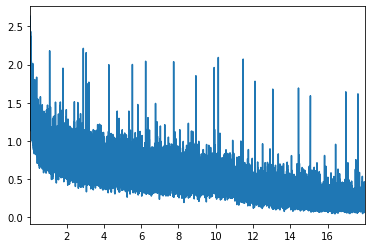

In [22]:
history['train_loss'].iloc[100:].plot();

In [20]:
def loadmodel(model,file):
    loc = torch.load(file, map_location='cuda:0')
    model.load_state_dict(loc)
    model.eval();
    model.cuda();
    return model

In [29]:
model = loadmodel(model, './effnet/KFold/8.pth')
model = nn.DataParallel(model)
torch.save(model.state_dict(), 'test.pth')

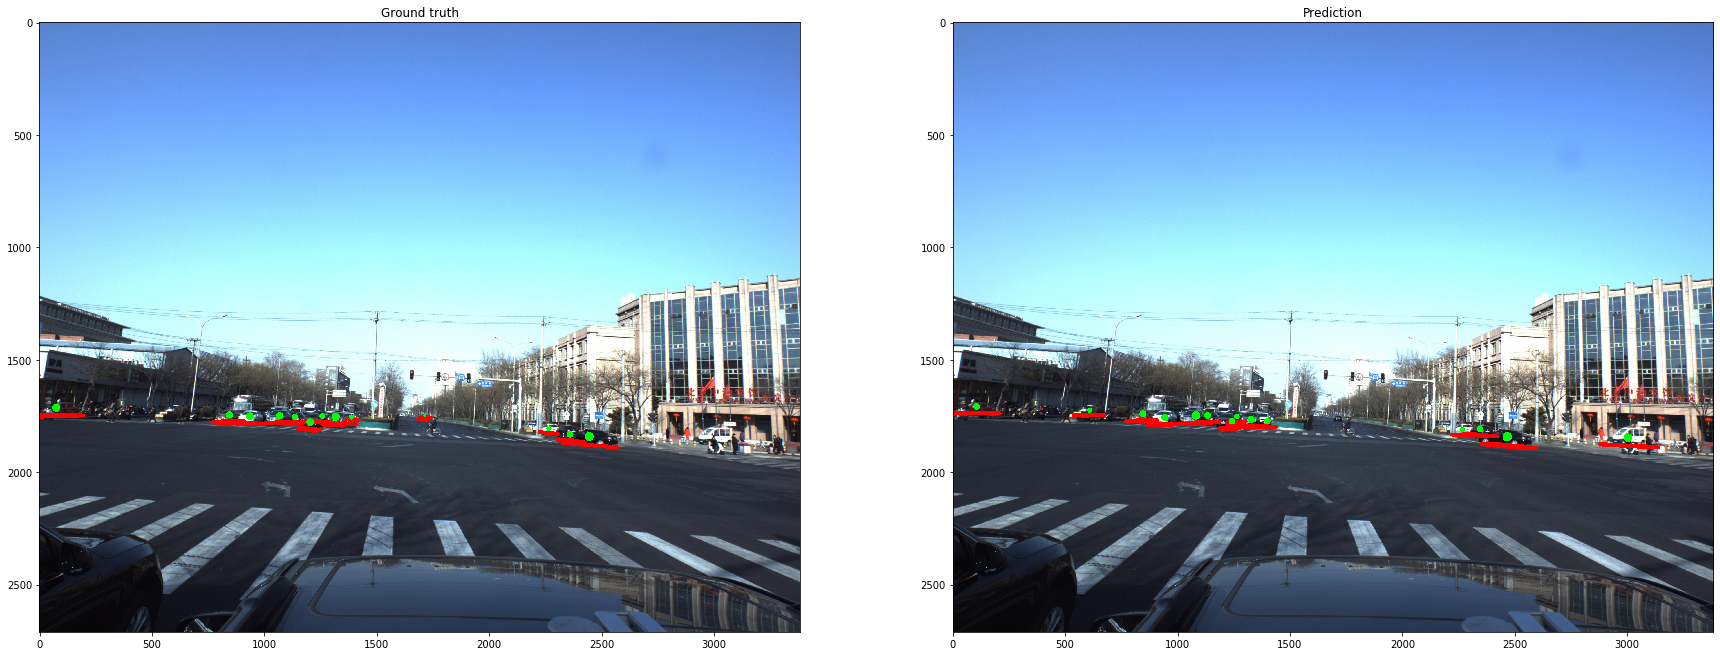

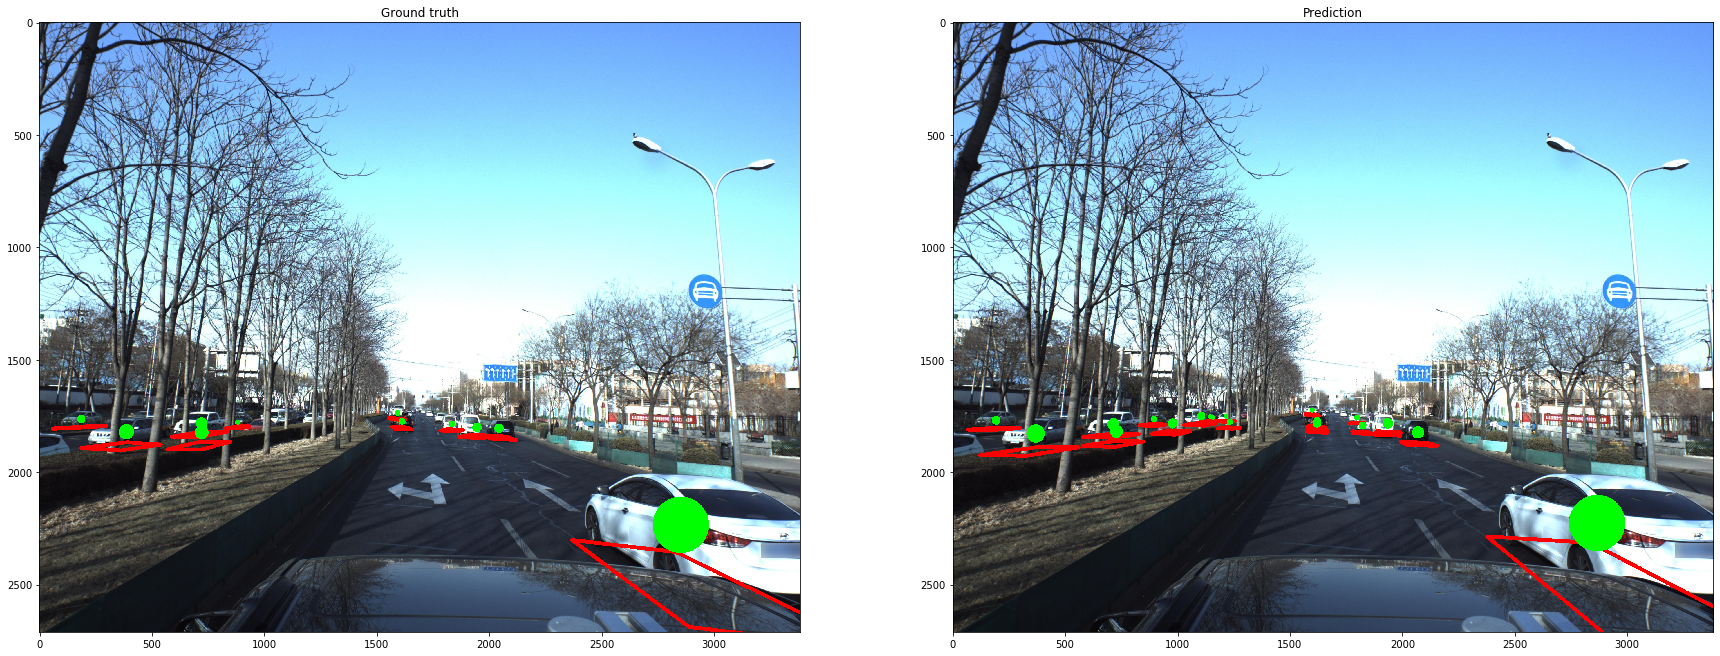

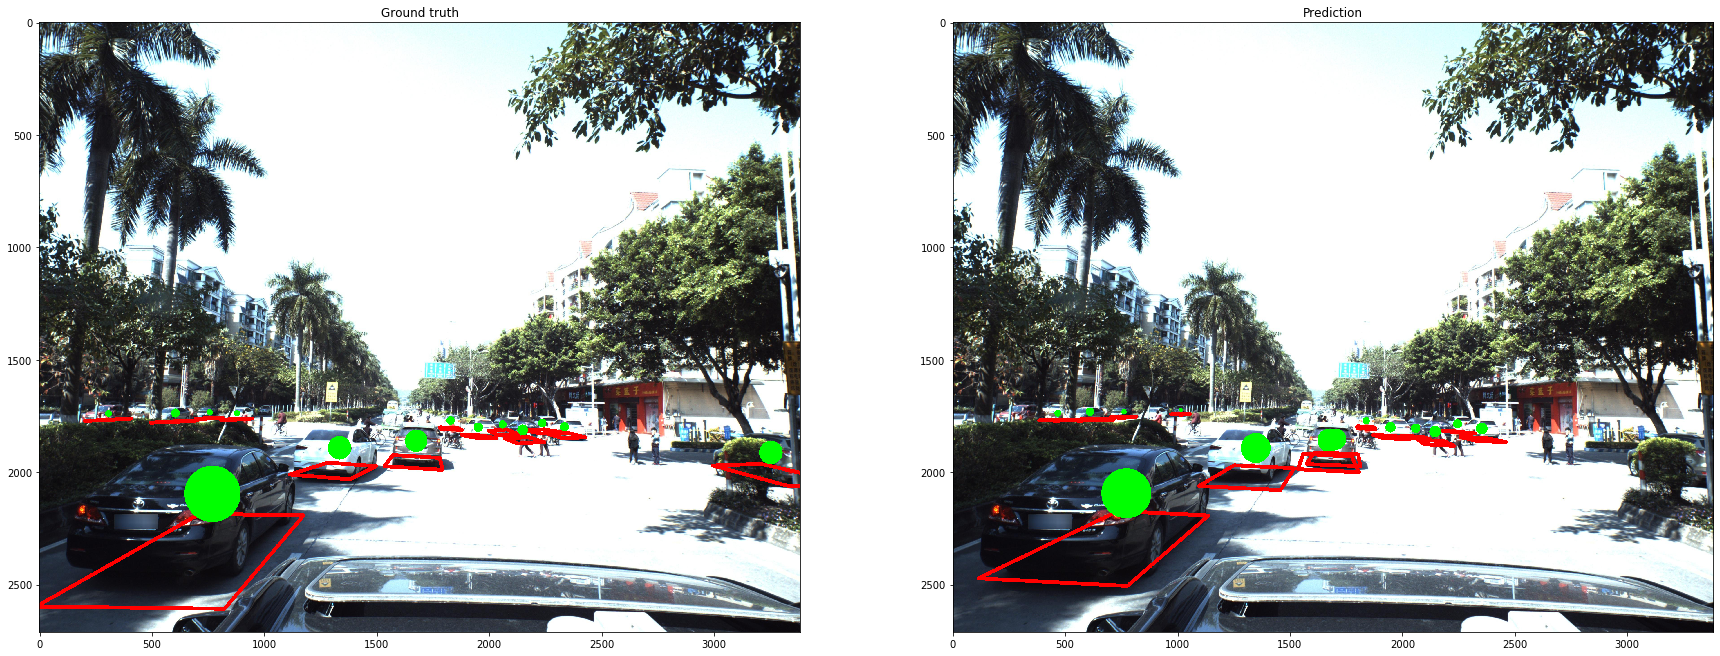

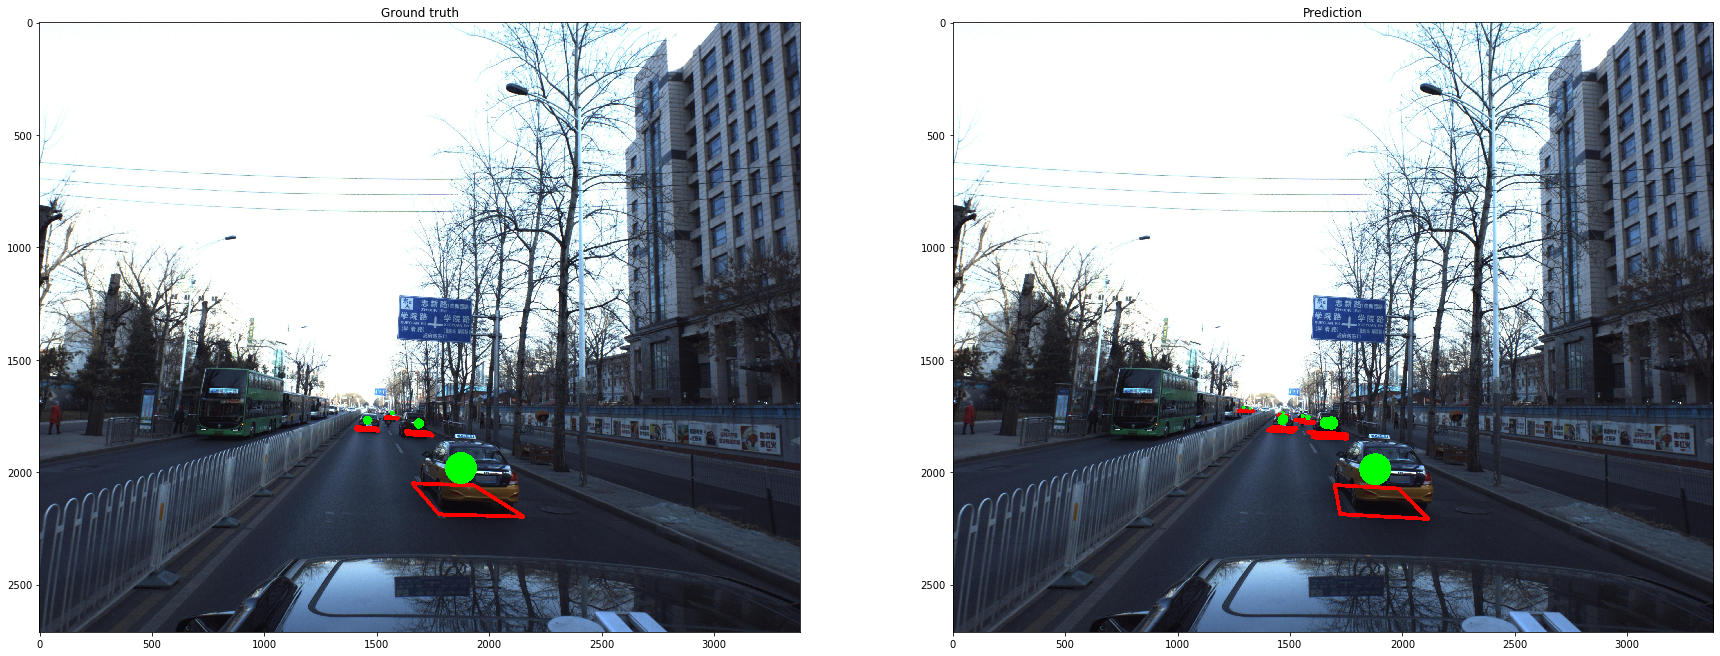

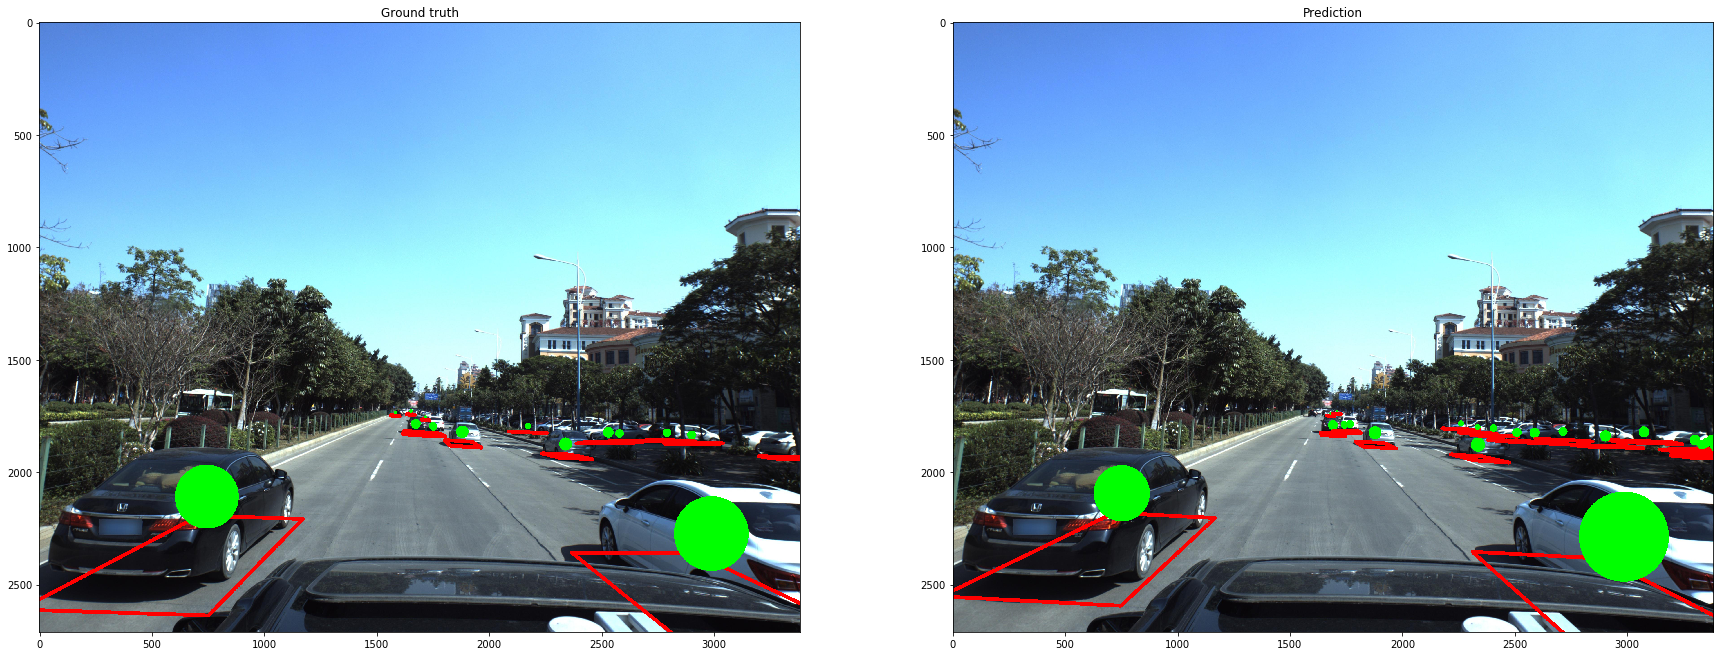

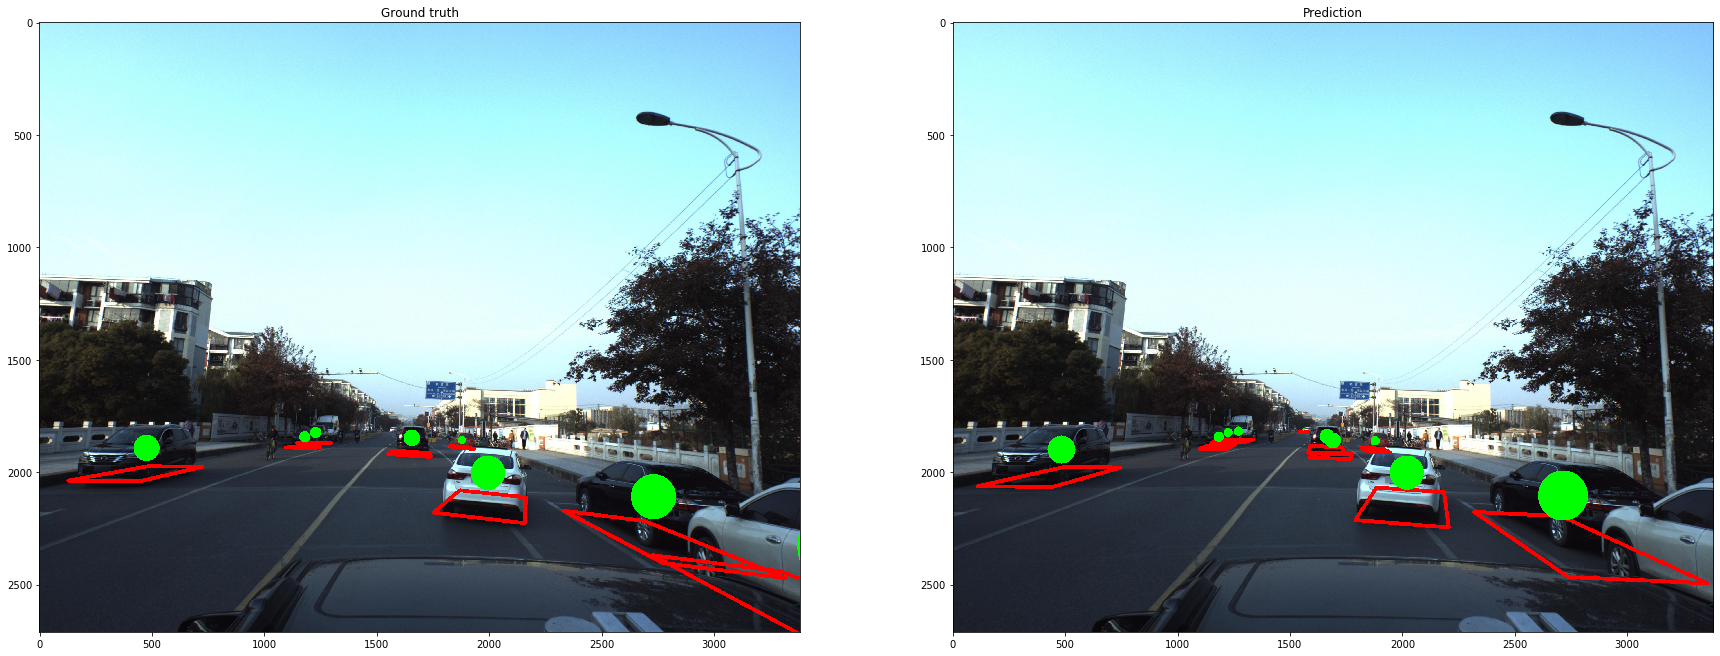

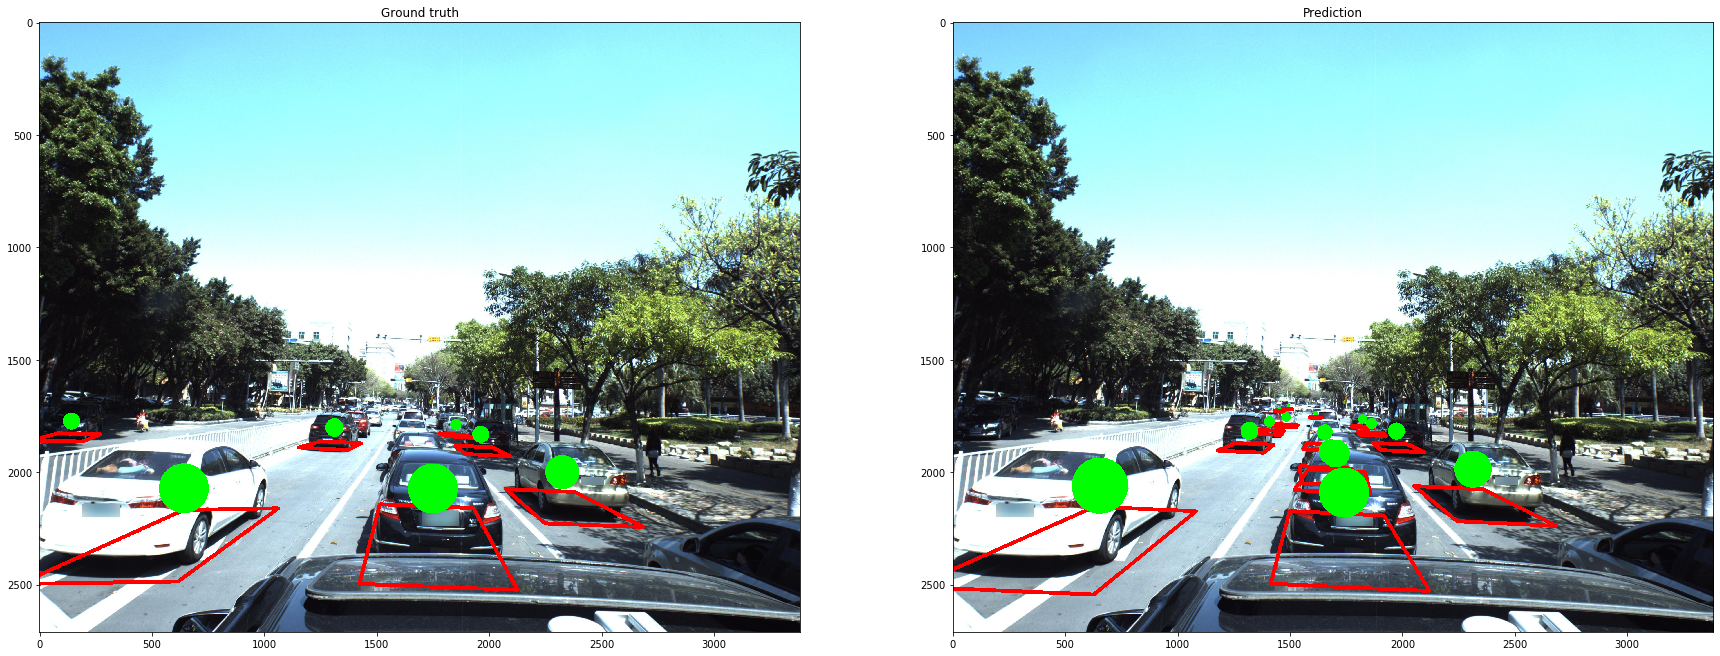

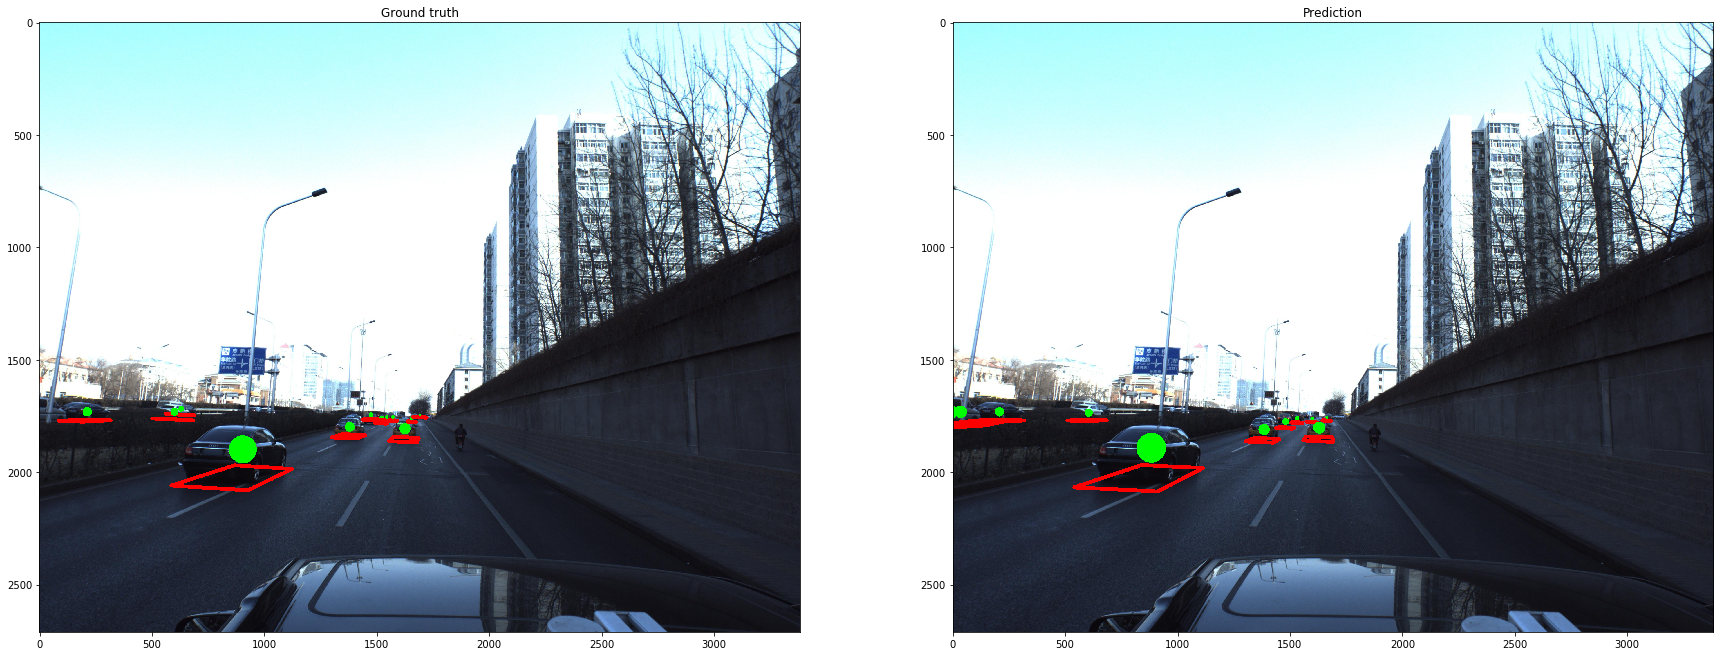

In [48]:
torch.cuda.empty_cache()
gc.collect()

for idx in range(8):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    coords_pred = extract_coords(output[0], -1.)
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0), 0.)
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

In [27]:
outputlist = []
model.eval()
for img, _, _ in tqdm(dev_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    outputlist.append(output)

In [21]:
def extract_coords(prediction, thr):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > thr)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

In [42]:
for thr in [-1.]:
    
    val_preds = []
    for output in tqdm(outputlist):
        for out in output:
            coords = extract_coords(out, thr)
            s = coords2str(coords)
            val_preds.append(s)

    df_dev2['PredictionString'] = val_preds
    df_dev2.to_csv('val_predictions.csv', index=False)

    valid_df = pd.read_csv('val_predictions.csv')
    expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
    valid_df = valid_df.fillna('')

    train_df = pd.read_csv('./data/train.csv')
    train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
    # data description page says, The pose information is formatted as
    # model type, yaw, pitch, roll, x, y, z
    # but it doesn't, and it should be
    # model type, pitch, yaw, roll, x, y, z
    expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

    max_workers = 10
    n_gt = len(expanded_train_df)
    ap_list = []
    p = Pool(processes=max_workers)
    for result_flg, scores in p.imap(check_match, range(10)):
        if np.sum(result_flg) > 0:
            n_tp = np.sum(result_flg)
            recall = n_tp/n_gt
            ap = average_precision_score(result_flg, scores)*recall
        else:
            ap = 0
        ap_list.append(ap)
    mAP = np.mean(ap_list)
    print(thr, mAP)

-1.0 0.16897327131218318


In [45]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, num_workers=4)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out, -2.)
        s = coords2str(coords)
        predictions.append(s)

In [24]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, num_workers=4)

numfold = [0,1,2,3,4,5,6,8]

for img, _, _ in tqdm(test_loader):
    outputlist = []
    for i in numfold:
        model = loadmodel(model, './effnet/KFold/{}.pth'.format(i))
        model.eval()
        with torch.no_grad():
            output = model(img.to(device))
        output = output.data.cpu().numpy()
        outputlist.append(output)
    
    output_mean = sum(outputlist)/len(numfold)
    
    for out in output_mean:
        coords = extract_coords(out, -1.5)
        s = coords2str(coords)
        predictions.append(s)

In [25]:
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
test.head()

ImageId                                   PredictionString
0  ID_18fb86d04                                                   
1  ID_ce06d4dc1  0.15038791 0.11098396965049792 -3.101147165643...
2  ID_afe07078f  0.14483693 0.16525788954433512 -3.097274320321...
3  ID_37caf75aa  0.1419963 -0.007832674071471472 -3.08337003936...
4  ID_7655363ca  0.14419131 -3.0908330185279516 -3.111000502603...

In [20]:
test_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, num_workers=4)

numfold = [0,2,3,4,6,7,8]
output_mean_list = []

for img, _, _ in tqdm(test_loader):
    outputlist = []
    for i in numfold:
        model = loadmodel(model, './effnetb0/KFold/{}.pth'.format(i))
        model.eval()
        with torch.no_grad():
            output = model(img.to(device))
        output = output.data.cpu().numpy()
        outputlist.append(output)
    
    output_mean = sum(outputlist)/len(numfold)
    output_mean_list.append(output_mean)

In [21]:
pickle.dump(output_mean_list, open('effnetb0.pkl','wb'))